In [136]:
## TanDEM-X time series vs plot measured AGB changes

# Use only data up to the time of the second field census (july 2020)

# Plot the metrics that showed the strongest relationships against UAV data

# Show that there is no clear relationship with AGB loss in the four plots

In [139]:
import rioxarray as rx
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import scipy.optimize as optimize
from scipy.stats import pearsonr
import geopandas as gpd
import pandas as pd

# Cumlative Sum of Residuals Formula

def CSR(a):
    mean = np.mean(a, axis=0)
    resid = a - mean
    return np.nancumsum(resid,axis=0)

def get_max_CSR(a):
    return xr.apply_ufunc(CSR, a).max(dim='t')

def get_min_CSR(a):
    return xr.apply_ufunc(CSR,a).min(dim='t')

def get_pixelsize(ds):
    metres = ds.rename({'lat':'y','lon':'x'}).rio.reproject('EPSG:5389')
    print((metres.x[1]-metres.x[0]).values)

def prepare(ds):
    ds = ds.rename({'x':'lon','y':'lat','band':'t'})
    AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)
    ds = ds.sel(lon=AOI_lon, lat=AOI_lat)   # Crop to AOI
    keep  = 3*np.array([0,1,2,3,4,5,6,6,7,8,10,11,12,13,14,15,18,19,20,21])
    ds   = ds.isel(t=keep).sel(t=slice('2019-06-01','2020-08-01'))
    csr = get_max_CSR(ds)                                             # Change detection feature height
    return csr

# def prepare_all(ds):
#     ds = ds.rename({'x':'lon','y':'lat','band':'t'})
#     AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)
#     ds = ds.sel(lon=AOI_lon, lat=AOI_lat)   # Crop to AOI
#     csr = get_max_CSR(ds)                                             # Change detection feature height
#     return csr

In [142]:
# -------------------------------------------------------------------------------------------------
# Read in Data ------------------------------------------------------------------------------------
os.chdir('/disk/scratch/local.4/harry/TDX/')

dem = xr.open_dataset('DEM_timeseries/DEM_timeseries_3m.nc')
asc = xr.open_dataset('intensity/nc/ascending.nc')
desc = xr.open_dataset('intensity/nc/descending.nc')
uav = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(uav)
uav = uav.sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})

os.chdir('/exports/csce/datastore/geos/users/s1332488/Chapter3/S1')

VV = rx.open_rasterio('S1_BelgicaVV.tif').rio.reproject('EPSG:4326')
VH = rx.open_rasterio('S1_BelgicaVH.tif').rio.reproject('EPSG:4326')

uav_S1 = uav.coarsen(lat=10,lon=10,boundary='trim').mean()


# -------------------------------------------------------------------------------------------------
# Extract features and merge datasets up to around second forest inventory July 2020
# -------------------------------------------------------------------------------------------------

AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)

keep  = [0,1,2,3,4,5,6,6,7,8,10,11,12,13,14,15,18,19,20,21]
dem   = dem.isel(t=keep)                                             # Remove images with artefacts
dem = dem.sel(t=slice('2019-06-01','2020-08-01'))
coh = dem.coherence.sel(lon=AOI_lon, lat=AOI_lat)                    # Crop to AOI
dem = dem.height.sel(lon=AOI_lon, lat=AOI_lat)
uav = uav.sel(lon=AOI_lon, lat=AOI_lat)
asc = asc.sel(lon=AOI_lon, lat=AOI_lat, t=slice('2019-06-01','2020-08-01'))
desc = desc.sel(lon=AOI_lon, lat=AOI_lat, t=slice('2019-06-01','2020-08-01'))

# Firstly DEM / coherence data and UAV data. Pixel size is 3m
uavD  = uav.where(uav > -100).interp_like(dem).rename('uav')         # Regrid to match TDX
h_csr = get_max_CSR(dem)                                             # Change detection feature height
trend = dem.polyfit('t',1).sel(degree=1).polyfit_coefficients        # Slope of height change
trend = (trend * (dem.t[-1] - dem.t[0]).astype(np.float64)   )       # Converted to metres

dem   = xr.merge([uavD,h_csr.rename('x0'),trend.rename('x1')])       # Merge datasets                     
# weights = coh.mean(dim='t')                                          # Coarsen to 50 m with weights?
# weighted_x0 = (dem.x0*weights).coarsen(lat=15,lon=15,boundary='trim').sum() 
# weighted_x0 = weighted_x0 / weights.coarsen(lat=15,lon=15,boundary='trim').sum()
# weighted_x1 = (dem.x1*weights).coarsen(lat=15,lon=15,boundary='trim').sum() 
# weighted_x1 = weighted_x1 / weights.coarsen(lat=15,lon=15,boundary='trim').sum()
# uav_coarse = dem.uav.coarsen(lat=15,lon=15,boundary='trim').mean()
# dem   = xr.merge([uav_coarse.rename('uav'),weighted_x0.rename('x0'),weighted_x1.rename('x1')])

# dem = dem.coarsen(lat=15,lon=15,boundary='trim').mean()

coh   = xr.merge([uavD,coh.rename('coh')])                          # Merge datasets

# Now intensity data. Pixel size is 2.65m

uavI = uav.where(uav > -100).interp_like(desc).rename('uav')  # Regrid to match TDX
asc  = get_max_CSR(asc).intensity.rename('x0')                # Change detection feature ascending
desc = get_max_CSR(desc).intensity.rename('x1')               # Change detection feature descending
asc  = asc.interp_like(desc)                                  # Regrid so pass directions match each other

intensity = xr.merge([uavI,asc,desc])                                  # Merge datasets
# intensity = intensity.coarsen(lat=20,lon=20,boundary='trim').mean()      # Coarsen to 10 m
# -------------------------------------------------------------------------------------------------

# Find stats on coherence layer at 1/4 ha
coh['anom'] = coh.coh - coh.coh.mean(dim=['lat','lon'])  # Remove trend due to HoA
coh_std = coh.anom.coarsen(lat=5,lon=5,boundary='trim').std()
coh_uav = coh.uav.coarsen(lat=5,lon=5,boundary='trim').mean()
coh_x0 = get_max_CSR(coh.anom).coarsen(lat=5,lon=5,boundary='trim').mean()
coh_x1 = coh_std.polyfit('t',1).sel(degree=1).polyfit_coefficients
coh_x1 = coh_x1 * (coh_std.t[-1] - coh_std.t[0]).astype(np.float64) 
coh = xr.merge([coh_uav.rename('uav'), coh_x0.rename('x0'), coh_x1.rename('x1')])

# Double check pixel sizes and extents
print('DEM pixel size')
get_pixelsize(dem)
get_pixelsize(coh)
print('Intensity pixel size')
get_pixelsize(intensity)

csrVV= prepare(VV)
csrVH = prepare(VH)
csrVH = csrVH.interp_like(csrVV)
s1 = xr.merge([csrVV.rename('x0'),
               csrVH.rename('x1'),
               uav.interp_like(csrVV,method='nearest').rename('uav_S1')])

# Double check pixel sizes and extents
print('S1 pixel size')
get_pixelsize(s1)

get_pixelsize(s1_all)

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


DEM pixel size
2.991526650614105
14.885923426074442
Intensity pixel size
2.595169359294232
S1 pixel size
9.971175648097415
9.971175648097415


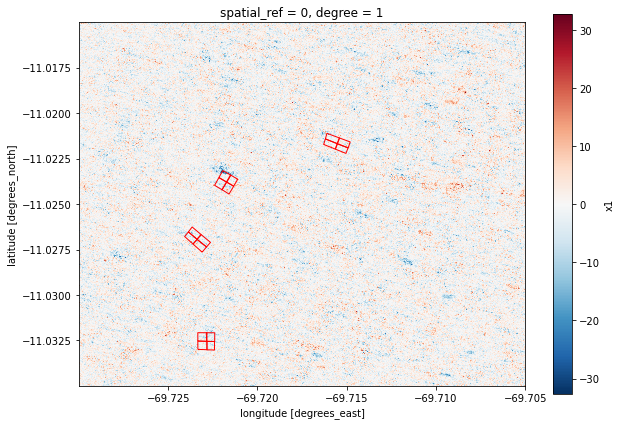

In [143]:
loc = '/home/s1332488/Chapter3/subplots_peru.shp'
plots = gpd.read_file(loc)

plt.figure(figsize=(10,7))
ax = plt.axes()
dem.x1.plot(ax=ax)
plots.boundary.plot(ax=ax,color='red',lw=1)
plt.show()

for plot in list(plots.subplot):
#     print(plot)
    plots.at[plots.subplot==plot,'I1'] = intensity.x0.rio.clip(plots[plots.subplot==plot].geometry).mean().values
    plots.at[plots.subplot==plot,'I2'] = intensity.x1.rio.clip(plots[plots.subplot==plot].geometry).mean().values
    plots.at[plots.subplot==plot,'H1'] = dem.x0.rio.clip(plots[plots.subplot==plot].geometry).mean().values
    plots.at[plots.subplot==plot,'H2'] = dem.x1.rio.clip(plots[plots.subplot==plot].geometry).mean().values
    plots.at[plots.subplot==plot,'coh'] = coh.x1.rio.clip(plots[plots.subplot==plot].geometry).mean().values
    plots.at[plots.subplot==plot,'S1_VV'] = s1.x0.rio.clip(plots[plots.subplot==plot].geometry).mean().values
    plots.at[plots.subplot==plot,'S1_VH'] = s1.x1.rio.clip(plots[plots.subplot==plot].geometry).mean().values
plots['LOSS'] = -plots.AGB_loss

Correlations excluding two outliers
-----
r,p for intensity:  -0.7522276673266193 0.0019113642602295164
-----
r,p for phase height:  0.54413408535673 0.04426359867250779
-----
Correlations including two outliers
-----
r,p for intensity:  -0.0270405633922339 0.9208162184418784
-----
r,p for phase height:  0.20269749917392765 0.4515166513159167
-----


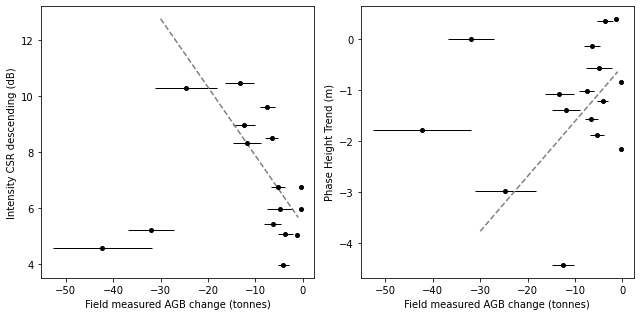

In [17]:
plt.figure(figsize=(9,4.5))#
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
# ax3 = plt.subplot(1,3,3)
# plots.plot.scatter(x='AGB_loss',y='I1',ax=ax,color='black',marker='x')
ax1.errorbar(plots['LOSS'],plots.I2,xerr=plots.dAGB_loss,color='black',marker='.',markersize=8,
            elinewidth=1,lw=0)
#                   ,label='Descending',fillstyle='none',lw=0)
ax1b = ax1
# ax1b.plot(plots['LOSS'],plots.I1,color='black',marker='.',markersize=6
#                   ,label='Ascending',lw=0)
# ax1b.set(ylabel='Intensity CSR descending (dB)')
ax2.errorbar(plots['LOSS'],plots.H2,xerr=plots.dAGB_loss,color='black',marker='.',markersize=8,
            elinewidth=1,lw=0)
# ax2.plot(plots['LOSS'],-plots['H2'],color='#42000a',marker='o',
#         markersize=6,fillstyle='none',lw=0,label='Trend')
# ax2b = ax2
# ax2b.plot(plots['LOSS'],plots['H1'],color='#42000a',marker='.',
#         markersize=6,lw=0,label='CSR')
# ax2b.set(ylabel='Phase Height CSR')
# plt.legend()

# ax3.plot(plots['LOSS'],plots.coh,color='#000a42',marker='o',markersize=6
#                   ,label='Coherence Trend',fillstyle='none',lw=0)

ax2.set(xlabel=' Field measured AGB change (tonnes) ',
       ylabel='Phase Height Trend (m)')
ax1.set(xlabel=' Field measured AGB change (tonnes) ',
       ylabel='Intensity CSR descending (dB)')
# ax3.set(xlabel='',
#        ylabel='Coherence trend')
# plt.xlim(0,50)
# plt.legend(loc='upper right')

cleaned = plots[plots.LOSS>-30]
I2_fit = np.polyfit(cleaned.LOSS,cleaned.I2,deg=1)
H2_fit = np.polyfit(cleaned.LOSS,cleaned.H2,deg=1)

xx = np.arange(-30,0)
I2_line = xx*I2_fit[0] + I2_fit[1]
H2_line = xx*H2_fit[0] + H2_fit[1]

ax1.plot(xx,I2_line,color='grey',ls='--')
ax2.plot(xx,H2_line,color='grey',ls='--')



print('Correlations excluding two outliers')
r,p = pearsonr(cleaned.LOSS,cleaned.I2)
print('-----')
print('r,p for intensity: ',r,p)
r,p = pearsonr(cleaned.LOSS,cleaned.H2)
print('-----')
print('r,p for phase height: ',r,p)
# print(cleaned.corr().LOSS[['I1','I2','H1','H2','coh']])
print('-----')

print('Correlations including two outliers')
r,p = pearsonr(plots.LOSS,plots.I2)
print('-----')
print('r,p for intensity: ',r,p)
r,p = pearsonr(plots.LOSS,plots.H2)
print('-----')
print('r,p for phase height: ',r,p)
# print(cleaned.corr().LOSS[['I1','I2','H1','H2','coh']])
print('-----')
# print('Correlations to percentage loss excluding two outliers')
# print(cleaned.corr().AGB_loss_p[['I1','I2','H1','H2','coh']])
# print('-----')

plt.tight_layout()
plt.savefig('/home/s1332488/Chapter3/Figures/TDX_vs_plots.png')
plt.show()


Correlations excluding two outliers
-----
r,p for VV:  -0.1761098103327084 0.5470111111460383
-----
r,p for VH:  -0.4192892953349542 0.13560587367989388
-----
Correlations including two outliers
-----
r,p for VV:  -0.07696302130598082 0.7769471148116396
-----
r,p for VH:  -0.20113818959936203 0.455078879256212
-----


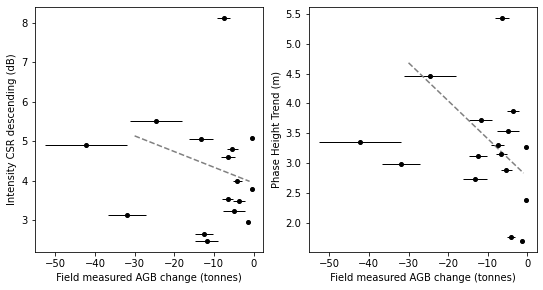

In [146]:
plt.figure(figsize=(9,4.5))#
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
# ax3 = plt.subplot(1,3,3)
# plots.plot.scatter(x='AGB_loss',y='I1',ax=ax,color='black',marker='x')
ax1.errorbar(plots['LOSS'],plots.S1_VV,xerr=plots.dAGB_loss,color='black',marker='.',markersize=8,
            elinewidth=1,lw=0)
#                   ,label='Descending',fillstyle='none',lw=0)
ax1b = ax1
# ax1b.plot(plots['LOSS'],plots.I1,color='black',marker='.',markersize=6
#                   ,label='Ascending',lw=0)
# ax1b.set(ylabel='Intensity CSR descending (dB)')
ax2.errorbar(plots['LOSS'],plots.S1_VH,xerr=plots.dAGB_loss,color='black',marker='.',markersize=8,
            elinewidth=1,lw=0)
# ax2.plot(plots['LOSS'],-plots['H2'],color='#42000a',marker='o',
#         markersize=6,fillstyle='none',lw=0,label='Trend')
# ax2b = ax2
# ax2b.plot(plots['LOSS'],plots['H1'],color='#42000a',marker='.',
#         markersize=6,lw=0,label='CSR')
# ax2b.set(ylabel='Phase Height CSR')
# plt.legend()

# ax3.plot(plots['LOSS'],plots.coh,color='#000a42',marker='o',markersize=6
#                   ,label='Coherence Trend',fillstyle='none',lw=0)

ax2.set(xlabel=' Field measured AGB change (tonnes) ',
       ylabel='Phase Height Trend (m)')
ax1.set(xlabel=' Field measured AGB change (tonnes) ',
       ylabel='Intensity CSR descending (dB)')
# ax3.set(xlabel='',
#        ylabel='Coherence trend')
# plt.xlim(0,50)
# plt.legend(loc='upper right')

cleaned = plots[plots.LOSS>-30]
VV_fit = np.polyfit(cleaned.LOSS,cleaned.S1_VV,deg=1)
VH_fit = np.polyfit(cleaned.LOSS,cleaned.S1_VH,deg=1)

xx = np.arange(-30,0)
VV_line = xx*VV_fit[0] + VV_fit[1]
VH_line = xx*VH_fit[0] + VH_fit[1]

ax1.plot(xx,VV_line,color='grey',ls='--')
ax2.plot(xx,VH_line,color='grey',ls='--')



print('Correlations excluding two outliers')
r,p = pearsonr(cleaned.LOSS,cleaned.S1_VV)
print('-----')
print('r,p for VV: ',r,p)
r,p = pearsonr(cleaned.LOSS,cleaned.S1_VH)
print('-----')
print('r,p for VH: ',r,p)
# print(cleaned.corr().LOSS[['I1','I2','H1','H2','coh']])
print('-----')

print('Correlations including two outliers')
r,p = pearsonr(plots.LOSS,plots.S1_VV)
print('-----')
print('r,p for VV: ',r,p)
r,p = pearsonr(plots.LOSS,plots.S1_VH)
print('-----')
print('r,p for VH: ',r,p)
# print(cleaned.corr().LOSS[['I1','I2','H1','H2','coh']])
print('-----')